## Preprocessing

In [4]:
user = 'Tian'
model_name = 'Test'

In [5]:
import sys

print ("Initializing global variables...", end=' ')
sys.stdout.flush()

# Filepaths
dict_path = './' + user + '/dictionaries/'
model_path = './' + user + '/models/'
hist_path = './' + user + '/histories/'
fig_path = './' + user + '/figs/'

# shared result file
output_file = './results.txt'

print ("Done")
print ("  Filepath set to " + user + "'s directory")

##################################################

print ("Importing modules...", end=' ')
import modules
print ("Done")

##################################################

print ("Reading data from disk...", end=' ')
sys.stdout.flush()

import numpy as np
import pandas as pd

df = pd.read_parquet('./Tian/Metal_all_20180116.snappy.parquet')

# Extract zinc-binded, single-chained protein sequences
df_zn = df.loc[df['ligandId'] == 'ZN']
df_zn_single = df_zn.loc[df_zn['interactingChains'] == 1]
seqs = np.array(df_zn_single.sequence)
target = np.array(df_zn_single.fingerprint)
cluster_numbers = np.array(df_zn_single.clusterNumber70)

del df,df_zn,df_zn_single

# Remove seqs containing 'U' and 'X'
rows_to_delete = []
for i in range(seqs.shape[0]):
    if 'X' in seqs[i] or 'U' in seqs[i] or np.isnan(cluster_numbers[i]):
        rows_to_delete.append(i) 

        
seqs = np.delete(seqs, rows_to_delete, 0)
target = np.delete(target, rows_to_delete)
cluster_numbers = np.delete(cluster_numbers, rows_to_delete)
print ("Done")

##################################################

print ("Loading dictionaries...", end=' ')
sys.stdout.flush()

# ProtVec
seqs_dict_w2v = {}
with open(dict_path + "seq_n_gram_to_vec_dict_w_UX", 'r') as fp:
        seqs_dict_w2v = json.load(fp)

# One-hot
seqs_dict_onehot = {}
with open(dict_path + "seqs_dict_onehot", 'r') as fp:
        seqs_dict_onehot = json.load(fp)

# property
# blosum62
from proteinSequenceEncoder import property_encoder, blosum62_encoder 
AMINO_ACIDS21 = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', \
                 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'X', 'Y']
seqs_property = {}
seqs_blosum62 = {}
seqs_onehot_blosum = {}

for aa in AMINO_ACIDS21:
    seqs_property[aa] = property_encoder(aa)
    seqs_blosum62[aa] = blosum62_encoder(aa)
    if aa != 'X' and aa !='U':
        seqs_onehot_blosum[aa] = seqs_dict_onehot[aa] + blosum62_encoder(aa)[0]


print ("Done")

##################################################

print ("Performing cross validation split...", end=' ')
ratio = 0.9
split = int(ratio*len(seqs))
train_seqs, val_seqs = seqs[:split], seqs[split:]
train_label, val_label = target[:split], target[split:]
train_cluster, val_cluster = cluster_numbers[:split], cluster_numbers[split:]
print ("Done")
print ("  Ratio :", ratio)
print ("  Train_range :", 0, "-", split-1)
print ("  Val_range :", split, "-", len(seqs)-1)

Initializing global variables... Done
  Filepath set to Tian's directory
Importing modules... Done
Reading data from disk... Done
Loading dictionaries... Done
Performing cross validation split... Done
  Ratio : 0.9
  Train_range : 0 - 20502
  Val_range : 20503 - 22781


## Data Generator

- <font color=blue>One-hot Encoding</font>

In [6]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_dict_onehot, 
              'cluster_numbers': train_cluster}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_dict_onehot, 
            'cluster_numbers': val_cluster}
common_args = {'batch_size': 100,
               'input_shape': (706, 20),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.OneHotGenerator(**train_args, **common_args)
val_gen = modules.OneHotGenerator(**val_args, **common_args)

Number of clusters 2140
Number of clusters 771


- <font color=blue>ProtVec Encoding</font>

In [7]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_dict_w2v}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_dict_w2v}
common_args = {'batch_size': 100,
               'input_shape': (706, 100),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.ProtVecGenerator(**train_args, **common_args)
val_gen = modules.ProtVecGenerator(**val_args, **common_args)

- <font color=blue>Property Encoding</font>

In [ ]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_property}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_property}
common_args = {'batch_size': 100,
               'input_shape': (706, 7),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.OneHotGenerator(**train_args, **common_args)
val_gen = modules.OneHotGenerator(**val_args, **common_args)

- <font color=blue>Blosum62 Encoding</font>

In [ ]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_blosum62}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_blosum62}
common_args = {'batch_size': 100,
               'input_shape': (706, 20),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.OneHotGenerator(**train_args, **common_args)
val_gen = modules.OneHotGenerator(**val_args, **common_args)

- <font color=blue>One-hot + Blosum62 Encodings</font>

In [ ]:
train_args = {'sequences': train_seqs,
              'labels': train_label,
              'translator': seqs_onehot_blosum}
val_args = {'sequences': val_seqs,
            'labels': val_label,
            'translator': seqs_onehot_blosum}
common_args = {'batch_size': 100,
               'input_shape': (706, 40),
               'label_shape': (706, 1),
               'shuffle': True}

train_gen = modules.OneHotGenerator(**train_args, **common_args)
val_gen = modules.OneHotGenerator(**val_args, **common_args)

## Model
- <font color=blue>Single BRNN</font>

In [4]:
# ProtVec:100, One-hot:20, blosum62:20, property:7
dimension = 20
cutoff = 706

from keras.layers import LSTM, Dense,Dropout, TimeDistributed, Bidirectional, Input, Concatenate, Flatten
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD, RMSprop
# Visualization
from keras.utils import plot_model

input_shape = (cutoff, dimension)
lstm_size = 64

input_0 = Input(shape=input_shape)
bd_lstm_0 = Bidirectional(LSTM(lstm_size, return_sequences=True), 
                          input_shape=input_shape, 
                          merge_mode='ave')(input_0)      
do_0 = Dropout(0.2)(bd_lstm_0)
output_0 = TimeDistributed(Dense(1, activation='tanh'))(do_0)

optimizer = Adam(lr=0.0001)
model = Model(inputs=input_0, outputs=output_0)
model.compile(loss='binary_crossentropy', optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 706, 20)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 706, 64)           43520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 706, 64)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 706, 1)            65        
Total params: 43,585
Trainable params: 43,585
Non-trainable params: 0
_________________________________________________________________


- <font color=blue>Threshold: mean+2.33*std</font>

In [5]:
def threshold_func(y_in):
    factor = 2.33
    y_out = np.zeros_like(y_in)
    for i in range(y_in.shape[0]):
        th= np.mean(y_in[i]) + factor * np.std(y_in[i])
        y_out[i] = (y_in[i] > th)
    return y_out

- <font color=blue>Metric: F1 score</font>

In [6]:
cb = modules.F1_history(threshold_func)

model_args = {'model': model, 
              'generators': [train_gen, val_gen], 
              'callbacks': [cb], 
              'post_train_args': {'user': user, 
                                  'model': model_name, 
                                  'result': output_file, 
                                  'fig_path': fig_path}}

trainer = modules.Trainer(**model_args)

Callback initialized.
Assigning validation generator... Done
Matching input shape... Done
Matching output shape... Done
Trainer initialized.


Epoch 1/10
205/205 [==============================] - 385s 2s/step - loss: 0.0370
Epoch 2/10
205/205 [==============================] - 383s 2s/step - loss: 0.0259
Epoch 3/10
205/205 [==============================] - 383s 2s/step - loss: 0.0231
Epoch 4/10
205/205 [==============================] - 383s 2s/step - loss: 0.0216
Epoch 5/10
205/205 [==============================] - 383s 2s/step - loss: 0.0214
Epoch 6/10
205/205 [==============================] - 397s 2s/step - loss: 0.0203
Epoch 7/10
205/205 [==============================] - 394s 2s/step - loss: 0.0211
Epoch 8/10
205/205 [==============================] - 388s 2s/step - loss: 0.0199
Epoch 9/10
205/205 [==============================] - 407s 2s/step - loss: 0.0196
Epoch 10/10
205/205 [==============================] - 411s 2s/step - loss: 0.0196
[End of Training]


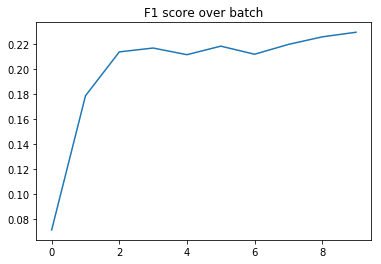

In [7]:
trainer.start(epoch=10)